In [1]:
!pip install tensorflow

In [6]:
!pip install pandas
!pip install scikit-learn


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 38.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.1/41.1 MB 35.1 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [1]:
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Lambda, Layer, Input, Dense, Concatenate
from tensorflow.keras.layers import Flatten, Conv1D, Reshape, GlobalAveragePooling2D,LSTM, BatchNormalization
import json
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

2024-08-03 23:16:51.439658: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-03 23:16:51.497173: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-03 23:16:51.515529: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-03 23:16:51.585326: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Set TensorFlow to use only the CPU
tf.config.set_visible_devices([], 'GPU')

I0000 00:00:1722727014.894542  166958 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722727014.963671  166958 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722727014.963742  166958 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs detected:")
    for gpu in gpus:
        print(f"- {gpu}")
else:
    print("No GPUs detected.")

GPUs detected:
- PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [4]:
def get_csrf_token(session):
    """Fetches the CSRF token from the login page."""
    login_url = "https://www.heartharena.com/login"
    response = session.get(login_url)
    soup = BeautifulSoup(response.text, 'html.parser')
    csrf_token = soup.find("input", {"name": "_csrf_token"})["value"]
    return csrf_token
    
def login(username, password):
    """Logs in to the HearthArena website."""
    url = "https://www.heartharena.com/login_check"
    session = requests.Session()

    # Get CSRF token
    csrf_token = get_csrf_token(session)

    # Prepare payload
    payload = {
        "_username": username,
        "_password": password,
        "_csrf_token": csrf_token,
        "_remember_me": "on"  # Optional, based on whether you want to stay logged in
    }

    # Submit the login form
    response = session.post(url, data=payload)

    # Check if login was successful
    if response.status_code == 200:
        print("Login successful!")
    else:
        print("Login failed.")

    return session



In [5]:
def getRuns(arenaURL,session):
    # Initialize an empty list to store the links
    response = session.get(arenaURL)
    links = []
    end = BeautifulSoup(response.text, 'html')
    runs = end.find('tbody')
    # Find all 'a' tags within 'tr' elements and filter for those with 'href' attribute starting with '/arena-run/'
    for link in runs.find_all('tr'):
        anchor_tags = link.find_all('a')
        for tag in anchor_tags:
            href = tag.get('href')
            if href and href.startswith('/arena-run/'):
                links.append('https://www.heartharena.com'+href)
    links = list(set(links))
    return links

In [6]:
def getStatsFromRun(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html')
    nameExtract = soup.select('h1.class')[0].text.strip()
    parts = nameExtract.split('/')
       
    wins = 0
    deckList = 0
    champ = ""
    hasData = len(soup.find_all('span', class_='wins'))
    print(hasData)
    if hasData == 1:
        champ = parts[0].strip() 
        wins = int(soup.find_all('span', class_='wins')[0].text)
        arenaDeck = soup.find_all('ul', class_="deckList")[0]
        cardNames = arenaDeck.find_all('span', class_='name')
        cardAmount = arenaDeck.find_all('span', class_='quantity')
        # Extract and convert numeric values and names
        namesList = [(name.text.strip()) for name in cardNames]
        amountList = [int(amount.text.strip()) for amount in cardAmount]

        # Initialize an empty list to hold the repeated names
        deckList = []

        # Iterate through the names and amounts simultaneously
        for name, amount in zip(namesList, amountList):
            # Repeat the name 'amount' times and extend the repeated_names list
            deckList.extend([name] * amount)

    return champ, wins/12, deckList, hasData

In [7]:
import csv
import json

In [8]:

# Path to the JSON file
file_path = 'my_dict.json'

# Load JSON file and convert it to a dictionary
with open(file_path, 'r') as file:
    encodedDeck = json.load(file)


In [9]:

        
def encodeDeck(deck):
    stats_list = []
    desc_list = []
    for name in deck:
        if name in encodedDeck:
            data = encodedDeck[name]
            stats = data[0]
            desc = data[1]
            stats_list.append(stats)
            desc_list.append(desc)
    
    
    return [stats_list, desc_list]

In [10]:
classes = ['Death Knight','Demon Hunter','Druid','Hunter','Mage','Paladin','Preist','Rogue','Shaman','Warlock','Warrior']

# Initialize an empty dictionary to hold the encoding
encoded_classes = {}

# Iterate over each class name
for name in classes:
    # Check if the name is already in the dictionary
    if name not in encoded_classes:
        # If not, add it with a unique integer
        encoded_classes[name] = len(encoded_classes) + 1



def encodeClass(classData):
    empty_list1 = [0] * len(encoded_classes)
    empty_list2 = [0] * len(encoded_classes)
    separated_names = classData.split(' + ')
    empty_list1[encoded_classes.get(separated_names[0])-1]+=1
    empty_list2[encoded_classes.get(separated_names[1])-1]+=1
    return empty_list1+empty_list2
    

In [11]:
def scrapeArenaData(linksList):
    # Initialize an empty list to store the outputs
    outputs = []

        # Iterate through linksList
    for link in linksList:
        # Call getStatsFromRun for each link and append the result to outputs
        
        output = getStatsFromRun(link)    
        outputs.append(output)

    return outputs

In [12]:
def getTrainingData(arenaData):
    winRateList = []
    DeckList = []
    classList = []
    descList = []
    
    for run in arenaData:
        print(run[3])
        if run[3] == 1:
            classEncoded = encodeClass(run[0])
            
            winRate = run[1]
            deckEncoded = encodeDeck(run[2])
            
            classList.append(classEncoded)
            DeckList.append(deckEncoded[0])
            descList.append(deckEncoded[1])
            winRateList.append(winRate)
    
    
    return [classList,DeckList,descList], winRateList
    

In [128]:
session = login("mcbrideslade@gmail.com", "U$!*3YFvJS2@Dvd4")
arenaUrl = 'https://www.heartharena.com/my-arenas'
linksList = getRuns(arenaUrl,session)

Login successful!


In [129]:
arenaData = scrapeArenaData(linksList)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [130]:
trainingdata, winratedata = getTrainingData(arenaData)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [142]:
inputdata1 = trainingdata[0]
inputdata2 = trainingdata[1]
inputdata3 = trainingdata[2]

inputdatanp1 = np.array(inputdata1, dtype=np.float32)
inputdatanp2 = np.array(inputdata2, dtype=np.float32)
inputdatanp3 = np.array(inputdata3, dtype=np.float32)

winratedatanp = np.array(winratedata, dtype=np.float32)
print(inputdatanp1.shape)
print(inputdatanp2.shape)
print(inputdatanp3.shape)

(25, 22)
(25, 30, 5)
(25, 30, 30, 300)


In [143]:
# Define the custom DeepSetLayer with Dropout
class DeepSetLayer(layers.Layer):
    def __init__(self, output_dim, phi_units=[12, 12], rho_units=[12, 12], dropout_rate=0.2):
        super(DeepSetLayer, self).__init__()
        self.phi_layers = []
        for units in phi_units:
            self.phi_layers.append(layers.Dense(units, activation='gelu'))
            self.phi_layers.append(layers.Dropout(dropout_rate))
        
        self.rho_layers = []
        for units in rho_units:
            self.rho_layers.append(layers.Dense(units, activation='gelu'))
            self.rho_layers.append(layers.Dropout(dropout_rate))
        
        self.output_layer = layers.Dense(output_dim)
    
    def call(self, inputs, training=False):
        # Apply the transformation function Φ to each element
        x = inputs
        for layer in self.phi_layers:
            if isinstance(layer, layers.Dropout):
                x = layer(x, training=training)
            else:
                x = layer(x)
        
        # Aggregate the transformed elements (averaging)
        #x = tf.reduce_mean(x, axis=1)
        x = tf.reduce_max(x, axis=1)
        
        # Apply the aggregation function ρ
        for layer in self.rho_layers:
            if isinstance(layer, layers.Dropout):
                x = layer(x, training=training)
            else:
                x = layer(x)
        
        # Output layer
        output = self.output_layer(x)
        return output

In [144]:
class MaskingLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(MaskingLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(MaskingLayer, self).build(input_shape)

    def call(self, inputs):
        stats_input, words_input = inputs
        
        # Generate a binary mask
        batch_size = tf.shape(stats_input)[0]
        num_cards = tf.shape(stats_input)[1]
        
        # Randomly choose cards to mask
        mask = tf.random.uniform(shape=(batch_size, num_cards), minval=0, maxval=2, dtype=tf.int32)
        
        # Ensure the same mask is used for both inputs
        mask = tf.cast(mask, dtype=tf.float32)
        
        # Apply mask to both inputs
        masked_stats = stats_input * mask[:, :, tf.newaxis]
        masked_words = words_input * mask[:, :, tf.newaxis, tf.newaxis]
        
        return masked_stats, masked_words




In [199]:
class RandomCardRemovalLayer(tf.keras.layers.Layer):
    def __init__(self, removal_prob=0.5, **kwargs):
        super(RandomCardRemovalLayer, self).__init__(**kwargs)
        self.removal_prob = removal_prob

    def call(self, inputs, training=None):
        stats, word_vectors = inputs
        
        if training:
            # Create a random mask for removal
            random_mask = tf.random.uniform((tf.shape(stats)[0],), 0, 1) > self.removal_prob
            random_mask = tf.cast(random_mask, tf.bool)
            
            # Apply mask to stats
            stats = tf.boolean_mask(stats, random_mask, axis=0)
            
            # Apply mask to word_vectors
            word_vectors = tf.boolean_mask(word_vectors, random_mask, axis=0)
        
        return stats, word_vectors

    def get_config(self):
        config = super(RandomCardRemovalLayer, self).get_config()
        config.update({"removal_prob": self.removal_prob})
        return config


In [200]:
class CardProcessingLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(CardProcessingLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        
        self.lstm_1 = tf.keras.layers.LSTM(20,return_sequences=False)
           

    def call(self, inputs, training=False):
        
        lstm_1 = tf.map_fn(lambda x: self.lstm_1(x), inputs, dtype=tf.float32)     

        return lstm_1



In [201]:
# Define the inputs
Class = tf.keras.Input(shape=(22,), name='Class')
Deck_stats = tf.keras.Input(shape=(None, 5), name='Deck_stats')
Card_desc = tf.keras.Input(shape=(30, None, 300), name='Card_desc')

Deck_stats_rem, Card_desc_rem = RandomCardRemovalLayer()([Deck_stats, Card_desc])



# Apply 1D Convolution
conv1d = CardProcessingLayer()(Card_desc_rem)




# Create the network for input_1
x1 = Dropout(.5)(Class)

x2 = DeepSetLayer(output_dim=20)(Deck_stats_rem)

x2 = BatchNormalization()(x2)

x3 = DeepSetLayer(output_dim=20)(conv1d)

x3 = BatchNormalization()(x3)

# Concatenate the outputs of the two networks
concatenated = layers.concatenate([x1, x2, x3])

x4 = layers.Dense(50, activation='gelu')(concatenated)

x4 = Dropout(.2)(x4)

# Add an output layer
output = layers.Dense(1)(x4)

# Define the model
model = Model(inputs=[Class, Deck_stats, Card_desc], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='mae', metrics=['mae'])
model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Deck_stats          │ (None, None, 5)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Card_desc           │ (None, 30, None,  │          0 │ -                 │
│ (InputLayer)        │ 300)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_card_remova… │ [(None, None, 5), │          0 │ Deck_stats[0][0], │
│ (RandomCardRemoval… │ (None, 30, None,  │            │ Card_desc[0][0]   │
│                     │ 300)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ card_processing_la… │ (None, 30, 20)    │     25,680 │ random_card_remo… │
│ (CardProcessingLay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Class (InputLayer)  │ (None, 22)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deep_set_layer_30   │ (None, 20)        │        800 │ random_card_remo… │
│ (DeepSetLayer)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deep_set_layer_31   │ (None, 20)        │        980 │ card_processing_… │
│ (DeepSetLayer)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_151         │ (None, 22)        │          0 │ Class[0][0]       │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20)        │         80 │ deep_set_layer_3… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20)        │         80 │ deep_set_layer_3… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_15      │ (None, 62)        │          0 │ dropout_151[0][0… │
│ (Concatenate)       │                   │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_190 (Dense)   │ (None, 50)        │      3,150 │ concatenate_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_160         │ (None, 50)        │          0 │ dense_190[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_191 (Dense)   │ (None, 1)         │         51 │ dropout_160[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 30,821 (120.39 KB)

 Trainable params: 30,741 (120.08 KB)

 Non-trainable params: 80 (320.00 B)

In [ ]:
# Train the model
model.fit([inputdatanp1,inputdatanp2, inputdatanp3], winratedatanp, epochs=500, batch_size=32)

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 0.5865 - mae: 0.5865
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.5288 - mae: 0.5288
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.9299 - mae: 0.9299
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.6651 - mae: 0.6651
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.4636 - mae: 0.4636
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.7036 - mae: 0.7036
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.3962 - mae: 0.3962
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.7815 - mae: 0.7815
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.6060 - mae: 0.6060
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.4538 - mae: 0.4538
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.3966 - mae: 0.3966
Epoch 12/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.2593 - mae: 0.2593
Epoch 13/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step 

In [194]:
prediction = model.predict([inputdatanp1,inputdatanp2, inputdatanp3])
flattened_list = [item for sublist in prediction for item in sublist]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step


In [195]:
list1 = winratedatanp
list2 = flattened_list

In [196]:
# Step 4: Combine arrays
combined_array = np.vstack([list1, list2])
# Extract the first row (keys)
first_row = combined_array[0]

# Sort the combined_array based on the first row
sorted_combined_array = np.array(sorted(zip(first_row, *combined_array[1:]), key=lambda x: x[0]))

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 25 and the array at index 1 has size 11

In [197]:
# Separate the two columns into lists
column_1 = sorted_combined_array[:, 0].tolist()
column_2 = sorted_combined_array[:, 1].tolist()

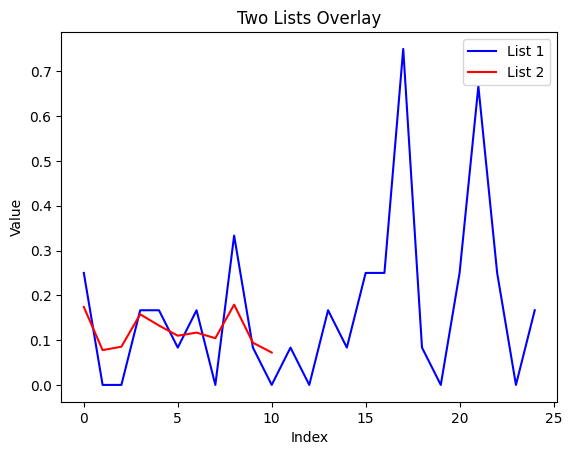

In [198]:
# Plotting
plt.plot(list1, label='List 1', color='blue')
plt.plot(list2, label='List 2', color='red')

# Customization
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Two Lists Overlay')
plt.legend()

# Display the plot
plt.show()